In [1]:
require(data.table)
files = sort(list.files(path = './sei_data/ukbb_heritability/seqclass_louvain_all',
            pattern= '*.results', full.name=T))
df = rbindlist(lapply(files, fread))
df$file = gsub('.sumstats.gz.formatted.sumstats.results','',rep(basename(files),each=41))


Loading required package: data.table


In [2]:

df$Enrichment_fdr = p.adjust(df$Enrichment_p, 'BH' )
enrichmat = dcast( df, Category~file, value.var='Enrichment')
enrichpmat = dcast( df, Category~file, value.var='Enrichment_p')
enrichfdrmat = dcast( df, Category~file, value.var='Enrichment_fdr')


df$Prop_lowbd = pmax(0,df$`Prop._h2` - 1. * df$`Prop._h2_std_error`)

df$Enrichment_z = qnorm(data.matrix(df$Enrichment_p)/2) * (2*(data.matrix(df$Enrichment)<0)-1)
df$Enrichment_z = pmax(0, df$Enrichment_z )

enrichpropmat = dcast( df, Category~file, value.var='Prop._h2')
enrichproplbmat = dcast( df, Category~file, value.var='Prop_lowbd')
enrichpropmat=data.frame(enrichpropmat)
enrichproplbmat=data.frame(enrichproplbmat)
row.names(enrichproplbmat)=enrichproplbmat$Category
row.names(enrichpropmat)=enrichpropmat$Category

enrichzmat = qnorm(data.matrix(enrichpmat[,2:48])/2) * (2*(data.matrix(enrichmat[,2:48])<0)-1)
enrichzmat = data.frame(enrichzmat)
row.names(enrichzmat) = enrichpmat$Category

In [3]:
ukbbnames=fread('./data/ukbb_sumstats.csv')
colnames(enrichproplbmat)[2:48] = ukbbnames$TRAIT[match(colnames(enrichproplbmat)[2:48],ukbbnames$FILE)]
colnames(enrichproplbmat)[2:48] = paste0( toupper(gsub('_.*','',ukbbnames$FILE[match(colnames(enrichproplbmat)[2:48], ukbbnames$TRAIT)])), ' | ', colnames(enrichproplbmat)[2:48])
colnames(enrichproplbmat)[2:48] = gsub('Corpular','Corpuscular',colnames(enrichproplbmat)[2:48])
df$trait =  ukbbnames$TRAIT[match(df$file,ukbbnames$FILE)]
df$trait = paste0( toupper(gsub('_.*','',ukbbnames$FILE[match(df$trait, ukbbnames$TRAIT)])), ' | ', df$trait)
df$trait =gsub('Corpular','Corpuscular', df$trait)
df$class = gsub('_REFL2_0','',df$Category)

In [4]:
#heatmap row and col order for visualization
#the order is generated with Hamiltonian path algorithm, if you have concorde TSP solver binary,
#you can generate orderx and ordery with code from the next cell
orderx = rev(c(18, 37, 40, 9, 14, 28, 5, 7, 11, 6, 16, 35, 21, 1, 38, 36, 24, 12, 25, 17, 15, 20, 31, 26, 29, 10, 22, 33, 34, 27, 2, 13, 3, 39, 23, 32, 19, 8, 30, 4))
ordery = rev(c(7, 12, 8, 9, 5, 2, 11, 6, 10, 4, 46, 30, 28, 19, 20, 36, 15, 14, 35, 13, 18, 17, 33, 34, 45, 16, 23, 37, 38, 47, 21, 22, 43, 44, 42, 41, 40, 39, 32, 27, 26, 3, 29, 1, 31, 24, 25))

In [5]:
#require(TSP)
#DIR_CONCORDE = '/XXX/YYY/'
#order.tsp<-function(d){
#  # solve heatmap ordering as minimum Hamiltonian path 
#  # problem which is solved as a special case of TSP. 
#  # Take distance as input
#  
#  d= rbind(0,cbind(0,as.matrix(d)))
#  concorde_path(DIR_CONCORDE)
#  solved=solve_TSP(TSP(d),method = 'concorde')
#  order.pre=as.numeric(solved)
#  order = order.pre[2:length(order.pre)]-1
#  return(order)
#}
#x = data.matrix(enrichproplbmat[1:40,2:48]*(enrichproplbmat[1:40,2:48]>0))
#orderx = order.tsp(dist(x))
#ordery = order.tsp(dist(t(x)))

In [6]:
require(plyr)
df$class= factor(df$class, gsub('_REFL2_0','',row.names(enrichproplbmat)[(orderx)]))
df$trait= factor(df$trait, colnames(enrichproplbmat)[2:48][rev(ordery)])

cnames = fread('../resources/cnames.tsv')
df$label = mapvalues(df$class, from=paste0('C',cnames$index), to = cnames$ID)
df$name = mapvalues(df$class, from=paste0('C',cnames$index), to = cnames$name)
df$label_name = mapvalues(df$class, from=paste0('C',cnames$index), to = paste(cnames$ID,cnames$name))
df$name_label = mapvalues(df$class, from=paste0('C',cnames$index), to = paste(cnames$name,cnames$ID))

Loading required package: plyr


Loading required package: ggplot2


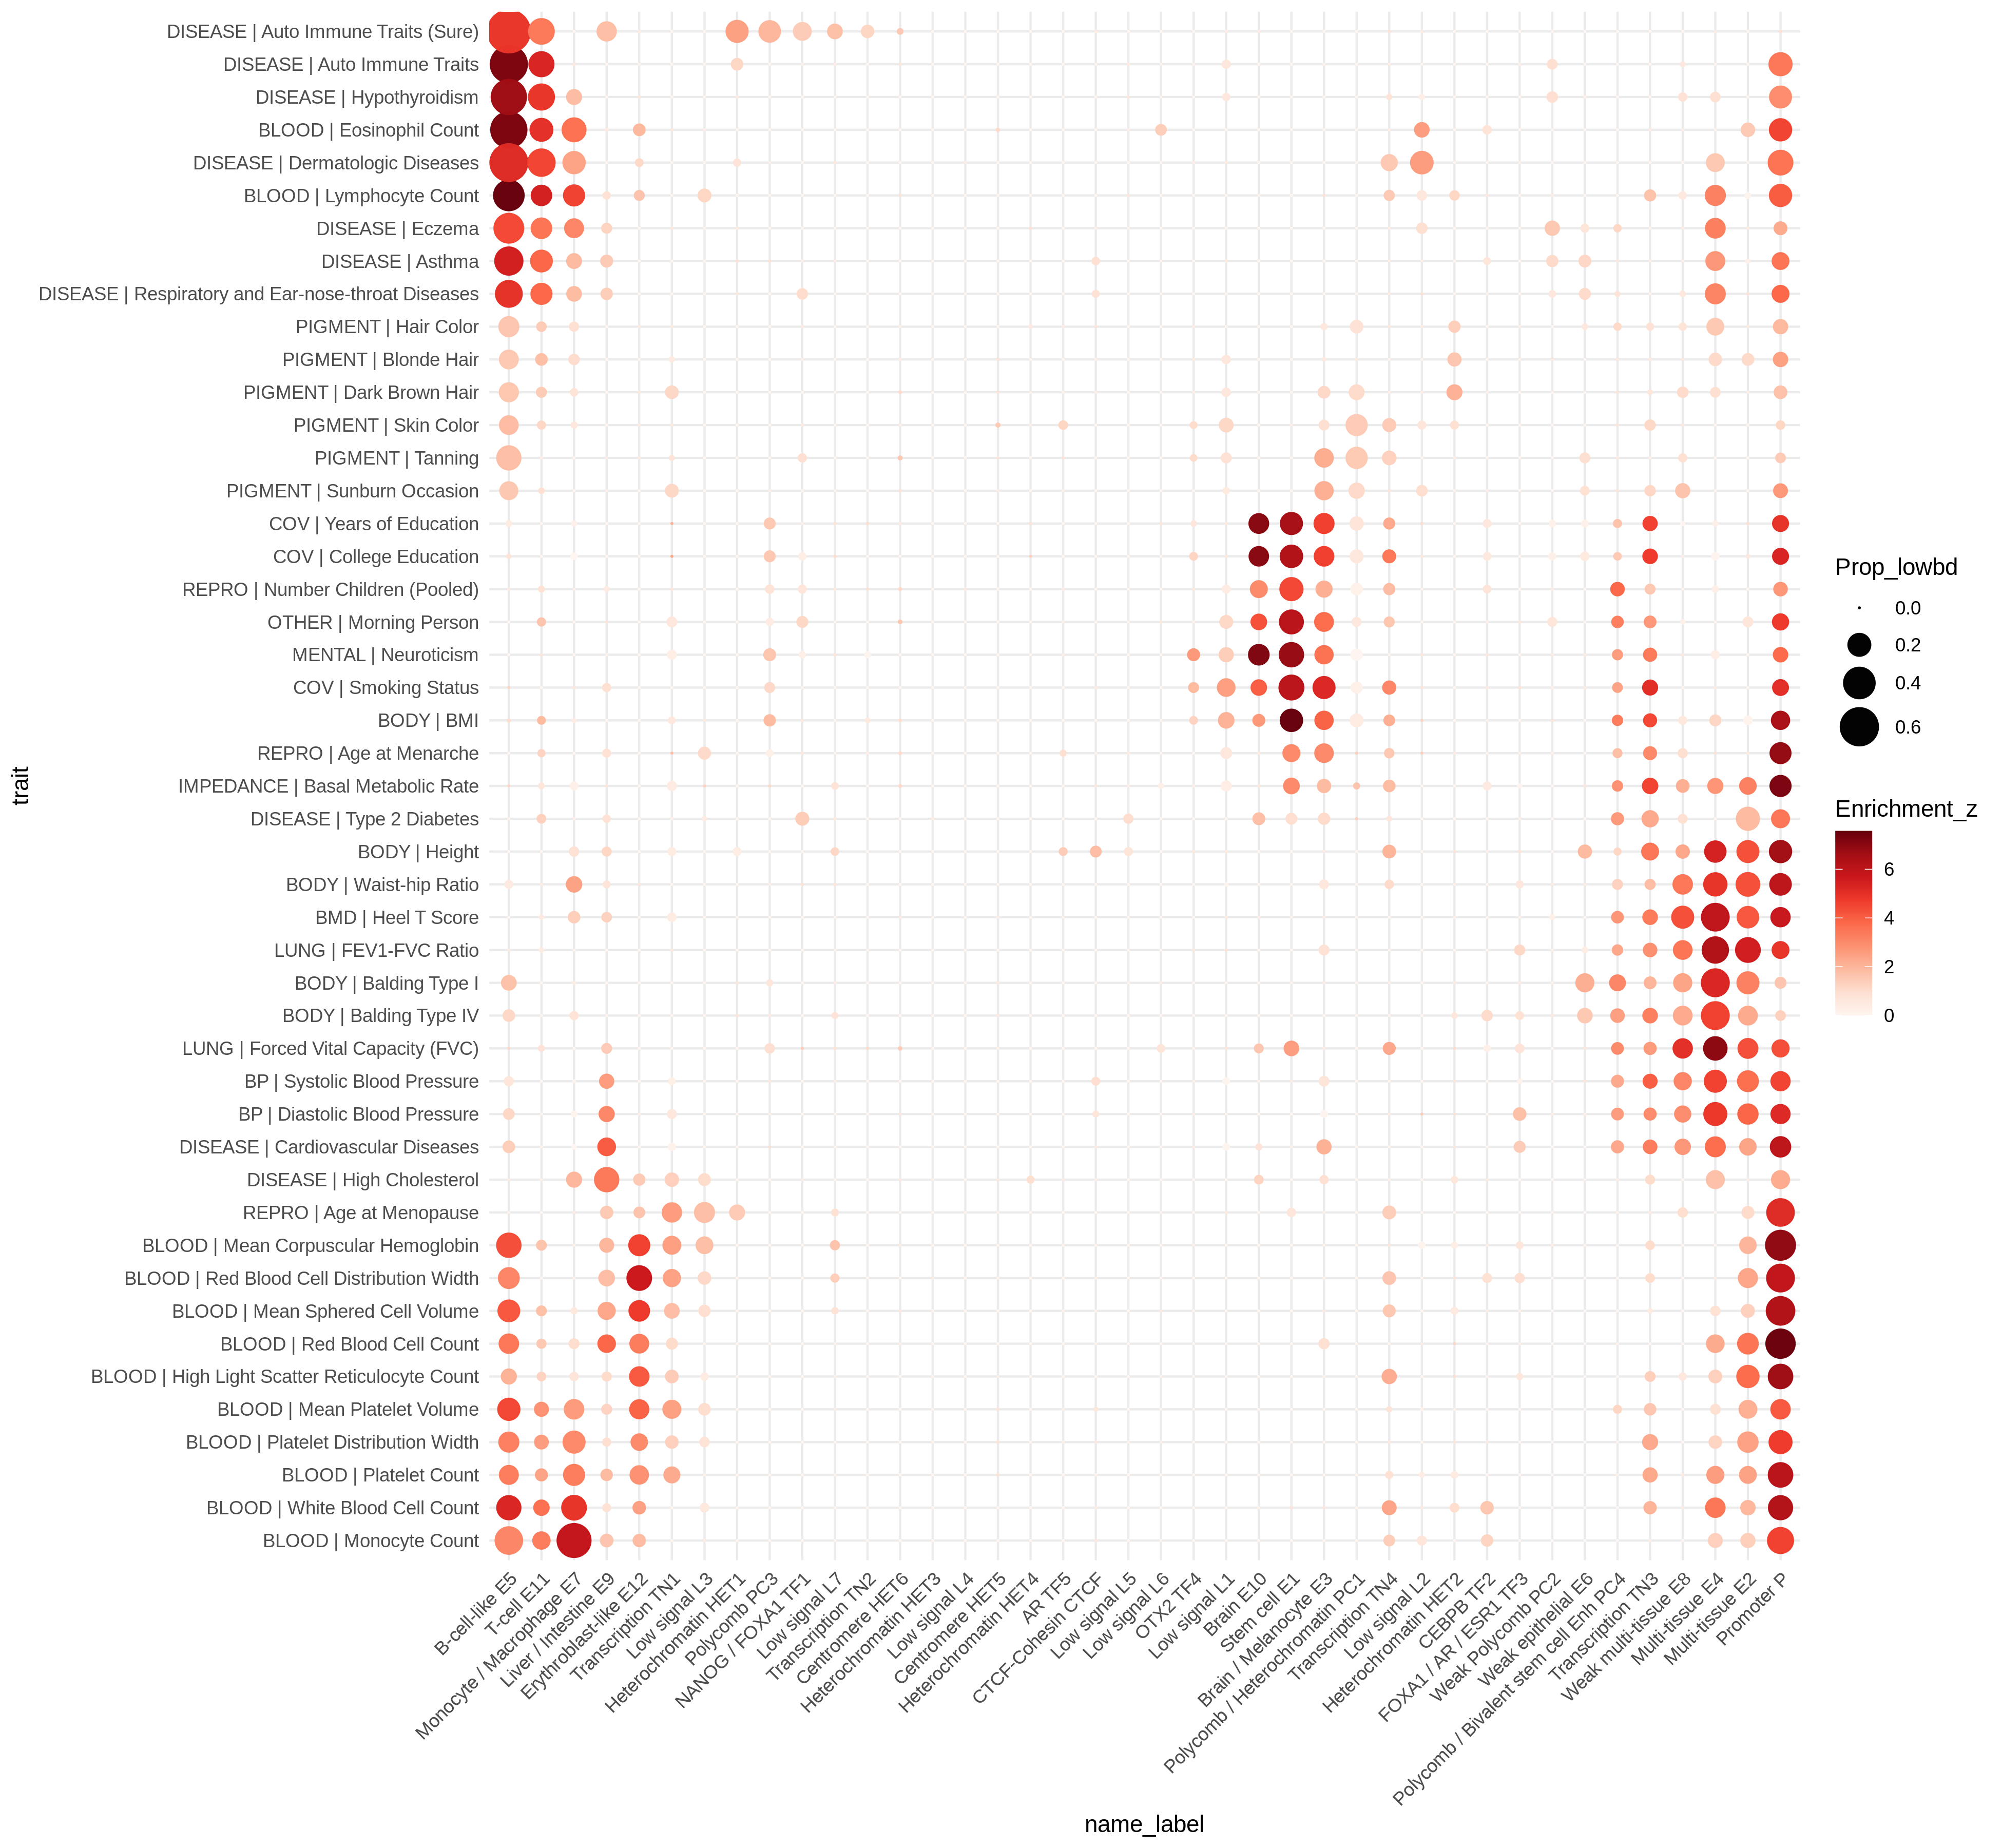

In [7]:
require(ggplot2)
options(repr.plot.res=300,repr.plot.width=13, repr.plot.height=12)

ggplot(df[grep('REFL2',Category),])+geom_point(aes(x=name_label,y=trait,
     size=`Prop_lowbd`,color=`Enrichment_z`), alpha=I(0.99))+theme_minimal()+scale_size_area(max_size=9)+
    scale_color_gradientn(colors=colorRampPalette(RColorBrewer::brewer.pal(9,'Reds'))(255))+
     theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
ggsave('./figures/gwas.ldsr.partition.pdf',width=13,height=12,dpi=300)

In [8]:
df[ , Enrichment_p_one_sided := 1-pnorm(qnorm(data.matrix(df$Enrichment_p)/2) * (2*(data.matrix(df$Enrichment)<0)-1))]
df[ , Enrichment_bh_one_sided := p.adjust(Enrichment_p_one_sided, 'BH' )]

In [9]:
write.csv(df[Category!='baseL2_0',c('trait','label_name','Prop_lowbd','Prop._SNPs','Enrichment_z','Enrichment_p_one_sided','Enrichment_bh_one_sided')],
          './sei_data/gwas.ldsr.seqclass_anno.partition.csv')

In [10]:
#conditioned on baseline
require(data.table)
files = sort(list.files(path = './sei_data/ukbb_heritability/seqclass_annot_with_baseline',
            pattern= '*.results', full.name=T))
df = rbindlist(lapply(files, fread))
df$file = rep(gsub('\\..*','',basename(files)), each=98)
df$trait = gsub('[0-9]+_','',df$file)

In [11]:
df = df[grepl('REF', Category),]
df[ , p_value_1sided := 1-pnorm(`Coefficient_z-score`)]
df[ , BH_1sided := p.adjust( p_value_1sided,method = 'BH')]

In [12]:
require(ggplot2)

df$trait =  ukbbnames$TRAIT[match(df$trait,ukbbnames$FILE)]
df$trait = paste0( toupper(gsub('_.*','',ukbbnames$FILE[match(df$trait, ukbbnames$TRAIT)])), ' | ', df$trait)
df$trait =gsub('Corpular','Corpuscular', df$trait)
df$class = gsub('_REFL2_0','',df$Category)


df$label_name = mapvalues(df$class, from=paste0("C",cnames$index), to = paste(cnames$ID,cnames$name))

In [13]:
df[`Coefficient_z-score`>0 & BH_1sided < 0.05][order(BH_1sided),.(label_name, trait, p_value_1sided, BH_1sided)]

label_name,trait,p_value_1sided,BH_1sided
<chr>,<chr>,<dbl>,<dbl>
E5 B-cell-like,DISEASE | Auto Immune Traits,4.985534e-11,9.352862e-08
E5 B-cell-like,BLOOD | Lymphocyte Count,5.695446e-10,5.342329e-07
E5 B-cell-like,DISEASE | Hypothyroidism,1.163620e-09,7.276506e-07
E5 B-cell-like,BLOOD | Eosinophil Count,1.746806e-07,6.554016e-05
E12 Erythroblast-like,BLOOD | Red Blood Cell Distribution Width,1.546715e-07,6.554016e-05
E7 Monocyte / Macrophage,BLOOD | Monocyte Count,5.429923e-07,1.697756e-04
L2 Low signal,BLOOD | Red Blood Cell Count,1.341937e-06,3.596391e-04
L2 Low signal,BLOOD | Monocyte Count,1.650752e-06,3.871014e-04
E10 Brain,COV | Years of Education,2.338040e-06,4.873514e-04


In [14]:
write.table(df[`Coefficient_z-score`>0 & BH_1sided < 0.05][order(BH_1sided),.(label_name, trait, p_value_1sided, BH_1sided)],
            './sei_data/gwas.ldsr.seqclass_anno.conditiononbaseline.tsv',sep='\t',row.names=F,quote=F)